In [1]:
from visual_behavior.data_access import loading
from visual_behavior.encoder_processing.running_data_smoothing import process_encoder_data
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Get table of experiments, choose a random sample of 1000

In [2]:
ophys_experiment_table = loading.get_filtered_ophys_experiment_table()
sessions = ophys_experiment_table.sample(1000, random_state=0)
sessions.head()

,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1003770203,1003647401,1003678703,1000740620,VisualBehaviorTask1B,holding,passed,20200129_492395_1imagesB,OPHYS_1_images_B,CAM2P.4,2020-01-29 21:14:40.000000,973776515,967938399,F,160.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],175,VISp,NaN,967938399,Vip-IRES-Cre,NaN,NaN,2,True,Vip_VISp_175
1010092802,1009837124,1009868108,1018027802,VisualBehaviorMultiscope4areasx2d,holding,passed,20200224_499478_2imagesG_passive,OPHYS_2_images_G_passive,MESO.1,2020-02-24 08:41:59.392974,994736136,990779724,F,140.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],167,VISl,NaN,990779724,Vip-IRES-Cre,NaN,z_drift_corr_um_diff,0,False,Vip_VISl_167
993593393,993450968,993496240,989461845,VisualBehaviorTask1B,completed,passed,20191210_485688_5imagesA,OPHYS_5_images_A_passive,CAM2P.3,2019-12-10 17:38:29.000000,952686300,940744053,M,149.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,940744053,Sst-IRES-Cre,NaN,NaN,0,False,Sst_VISp_275
850517356,849304162,849525884,1018028156,VisualBehaviorMultiscope,completed,passed,20190411_440631_multiscope_ophys1,OPHYS_1_images_A,MESO.1,2019-04-11 08:28:26.000000,821518844,813702151,M,121.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],350,VISl,NaN,813702151,Sst-IRES-Cre,mesoscope_pilot_datacube,NaN,0,True,Sst_VISl_350
959388792,958772311,958888263,1018028339,VisualBehaviorMultiscope,completed,passed,20191001_457841_5imagesB,OPHYS_5_images_B_passive,MESO.1,2019-10-01 08:25:28.921369,858992726,850862430,F,217.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],75,VISp,NaN,850862430,Sst-IRES-Cre,NaN,NaN,0,False,Sst_VISp_75


## define a function to get the running data stats for a given session

In [5]:
def get_running_speed_summary(oeid):
    print('getting running speed for oeid {}'.format(oeid))
    try:
        dataset = loading.get_ophys_dataset(oeid)
        dataset.running_data_df = process_encoder_data(
            dataset.running_data_df.reset_index(), 
            v_max='v_sig_max'
        )
        output_dict = {'oeid':oeid}
        output_dict.update(dataset.running_data_df['speed'].describe().to_dict())
        return output_dict
    except:
        return {'oeid':oeid}

In [7]:
func = get_running_speed_summary

## test on one session

In [4]:
%%time
oeid = 1003770203
get_running_speed_summary(oeid)

getting running speed for oeid 1003770203


CPU times: user 57.4 s, sys: 737 ms, total: 58.1 s
Wall time: 1min 35s


{'oeid': 1003770203,
 'count': 269922.0,
 'mean': 13.9101378540111,
 'std': 11.640093567611704,
 'min': -13.785008355198755,
 '25%': 1.6539036434983918,
 '50%': 14.314710295790592,
 '75%': 24.25276083724298,
 'max': 48.84998685723451}

## extract the running speed stats for each of the session samples using multiprocessing.pool

In [ ]:
%%time
with Pool(32) as pool:
    df = pool.map(get_running_speed_summary, sessions.index.values)
df = pd.DataFrame(df)

In [8]:
df

,oeid,count,mean,std,min,25%,50%,75%,max
0,1003770203,269922.0,13.910138,11.640094,-13.785008,1.653904,14.314710,24.252761,48.849987
1,1010092802,269963.0,28.416264,12.729540,-11.195103,21.845926,31.458183,37.993788,58.974621
2,993593393,270197.0,0.307941,1.353836,-6.617942,-0.201930,0.037588,0.310053,13.765441
3,850517356,270463.0,19.554783,10.372810,-8.169926,11.842442,19.515033,26.564314,58.544018
4,959388792,270107.0,0.226344,1.324117,-4.966388,-0.266396,0.024174,0.338549,13.804042
...,...,...,...,...,...,...,...,...,...
995,886587172,269812.0,9.920910,17.354639,-21.526178,-0.079458,0.312858,12.571312,80.155806
996,834279496,270292.0,23.515056,16.304812,-17.606532,10.723179,24.685595,35.464396,71.812207
997,871196375,269876.0,3.999579,8.648048,-12.514174,-0.162373,0.210160,1.460541,45.277883
998,886585123,269811.0,12.888338,19.492114,-13.168476,-0.108722,0.319588,29.535203,69.135254


Text(0, 0.5, 'count')

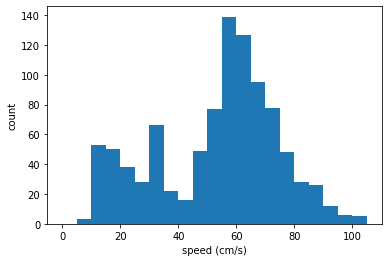

In [14]:
fig,ax=plt.subplots()
ax.hist(df['max'],bins=np.arange(0,110,5))
ax.set_xlabel('speed (cm/s)')
ax.set_ylabel('count')

In [ ]:
fig,ax=plt.subplots()
ax.hist(df['max'],bins=np.arange(0,110,5))
ax.set_xlabel('speed (cm/s)')
ax.set_ylabel('count')

In [13]:
df['max'].describe()

count    968.000000
mean      53.763744
std       21.366606
min        7.919533
25%       35.246085
50%       57.870910
75%       68.002556
max      113.878728
Name: max, dtype: float64